# *Oppenheimer* Movie Reviews Sentiment Analysis

This project is belong as a portfolio to <br/>
<b> *Eduardo Imanuel Bastian* </b>


<p align="center"><img src="3.OppenheimerSentiment/poster.jpeg" width="474px"></p>

## 1. Data Preparation

The data is prepared by scraping from IMDB reviews.

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Set up EdgeDriver options
options = webdriver.edge.options.Options()
options.add_argument('--headless')  # Run the browser in headless mode (without GUI)
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Path to the Edge WebDriver executable
# Note that this file is for Mac M1 devices
edge_driver_path = 'msedgedriver'

# Initialize EdgeDriver with the specified options
service = webdriver.edge.service.Service(edge_driver_path)
driver = webdriver.edge.webdriver.WebDriver(options=options,service=service)

# Get the url of the website
url = 'https://www.imdb.com/title/tt15398776/reviews?spoiler=hide&sort=curated&dir=desc&ratingFilter=0'
driver.get(url)
time.sleep(6)  # Wait for the page to load
# Click the "Load more" button repeatedly until it's no longer visible
while True:
    try:
        load_more_button = driver.find_element(by=webdriver.common.by.By.ID,value="load-more-trigger")
        load_more_button.click() # Click the "Load more" button
        time.sleep(2.5)  # Wait for the new reviews to load
    except:
        break

# Access the website
page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

# Find corresponding div that stores reviews data
text_elements = soup.find_all('div', {'class': 'text show-more__control'})

# Store all reviews data 
reviews = [review.text for review in text_elements]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
dataset=pd.DataFrame({'Reviews':reviews})
dataset.head()
dataset.to_csv('oppenheimer_reviews.csv', index=False)

## 2. Data Preprocessing

In [2]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

# Import spaCy library for preprocessing
nlp = spacy.load("en_core_web_sm")
# Load the dataset
dataset=pd.read_csv('3.OppenheimerSentiment/data/oppenheimer_reviews.csv')

In [3]:
# Inspect the number of reviews in the dataset
len(dataset)

819

In [4]:
# Word cleaning
df_word={'Old':["I've", "movie", "I'm"
                            ],
                     'New':['I have', 'film', 'I am'
                                 ]}

# Fixing the words and synonims
for i in range(len(dataset['Reviews'])):
    for j in range(len(df_word)):
        dataset['Reviews'][i]=dataset['Reviews'][i].replace(df_word['Old'][j],df_word['New'][j])

In [5]:
# Define a function to execute preprocessing steps
def preprocess_text_col(df):
    lemm_text = []
    for i in range(df.shape[0]):
        doc = nlp(str(df[i]))
        # Lower-casing
        low_arr = [tok.lower_ for tok in doc]
        low_string = " ".join(low_arr)
        doc = nlp(low_string)
        # Stop-words removal and Punctuation removal
        stp_punc_arr = [str(tok) for tok in doc if not tok.is_stop and not tok.is_punct]
        stp_punc_string = " ".join(stp_punc_arr)
        doc = nlp(stp_punc_string)
        # Lemmatization
        lemm_arr = [tok.lemma_ for tok in doc]
        lemm_string = " ".join(lemm_arr)
        doc_lem = nlp(lemm_string)
        lemm_text.append(lemm_string)
    return lemm_text

In [14]:
# Preprocess the reviews
dataset['Reviews']=preprocess_text_col(dataset['Reviews'])

# Tokenize the text data using spaCy
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

dataset['Tokens'] = dataset['Reviews'].apply(tokenize_text)

In [15]:
dataset

,Reviews,Tokens
0,come theater watch oppenheimer great experienc...,"[come, theater, watch, oppenheimer, great, exp..."
1,authentic audio visual journey era birth atomi...,"[authentic, audio, visual, journey, era, birth..."
2,m big fan nolan work look forward understand f...,"[m, big, fan, nolan, work, look, forward, unde..."
3,find film hate boring know know piece history ...,"[find, film, hate, boring, know, know, piece, ..."
4,masterpiece decent biopic interesting person g...,"[masterpiece, decent, biopic, interesting, per..."
...,...,...
814,indian adult film great kinda good nude film u...,"[indian, adult, film, great, kinda, good, nude..."
815,love film love actor effort hour feel fear col...,"[love, film, love, actor, effort, hour, feel, ..."
816,act tremendous true story pot gold feel way lo...,"[act, tremendous, true, story, pot, gold, feel..."
817,wow hype clip early year film justice scene sc...,"[wow, hype, clip, early, year, film, justice, ..."


## 3. Exploratory Data Analysis
EDA steps are: <br/>
1. Most frequent word
2. Bigrams analysis

### Most Occurring Words

In [9]:
# Combine all the reviews into a single string
def top_words(data,n):
    filtered_words = ' '.join(data['Reviews'])
    filtered_tok = nlp(filtered_words)

    # Remove stop words
    filtered_tok = [token.text for token in filtered_tok]
    # Calculate word frequencies using a dictionary
    word_freq = {}
    for word in filtered_tok:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

    # Sort the word frequencies in descending order
    sorted_word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}

    # Get the top 10 most frequent words and their counts
    top_15_words = list(sorted_word_freq.keys())[1:n]
    top_15_counts = list(sorted_word_freq.values())[1:n]

    # Plot the result in a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(top_15_words, top_15_counts)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {n} Most Frequent Words in Reviews')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

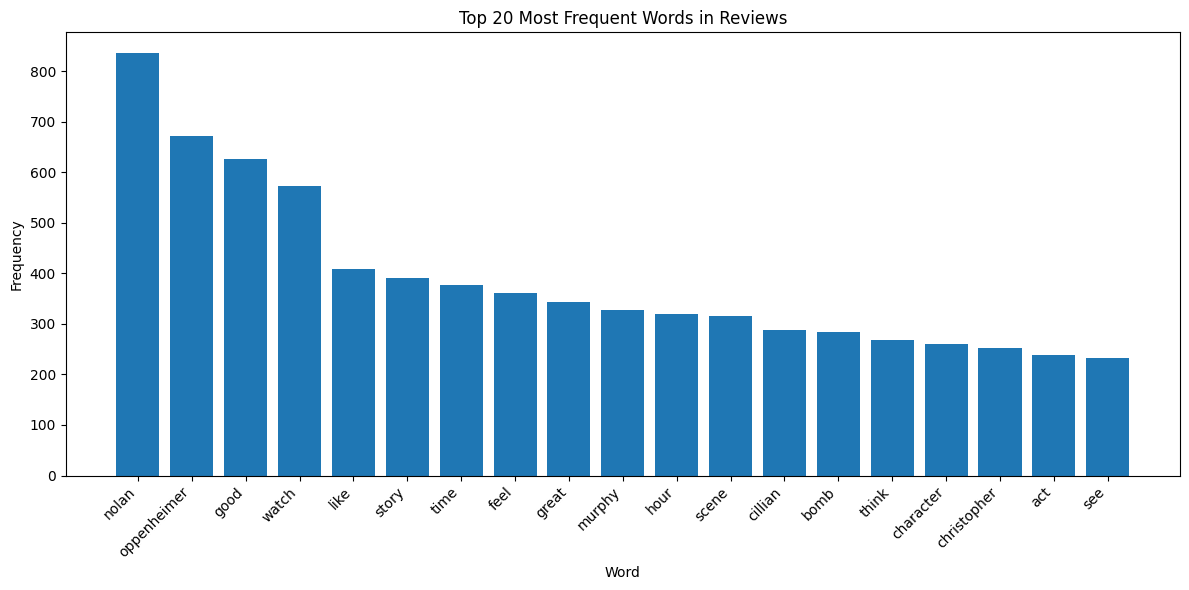

In [62]:
# Show most frequent words
top_words(dataset,20)

### TF-IDF highest scoring words

In [16]:
def tfidf_top_words(data,n,n_gram=100):
    # Generate the dictionary
    #lemm_text_arr = data['Reviews']
    #lemm_tokens = [doc.split() for doc in lemm_text_arr]
    try:
        lemm_tokens = data[f'{n_gram}-grams Tokens']
        print(f'Used {n_gram}-Grams')
    except:
        lemm_tokens = data['Tokens']
        print('Used Tokens')
    dictionary = Dictionary(lemm_tokens)
    dictionary.filter_extremes(no_below=2, no_above=0.9) # no_below: a word must occur in 2 different documents 
                                                        # no_above: ignore certain word that occurs in 90% of the documents in corpus

    # Generate the TF-IDF corpus
    lemm_corpus = [dictionary.doc2bow(doc) for doc in lemm_tokens]
    tfidf_model = TfidfModel(lemm_corpus)
    corpus_tfidf = tfidf_model[lemm_corpus]

    # Get the TF-IDF scores for each word in the corpus
    word_scores_tfidf = {}

    for doc_tfidf in corpus_tfidf:
        for word_id, tfidf_score in doc_tfidf:
            word = dictionary[word_id]
            if word in word_scores_tfidf:
                word_scores_tfidf[word] += tfidf_score
            else:
                word_scores_tfidf[word] = tfidf_score

    # Sort the words based on their TF-IDF score in descending order
    sorted_words_tfidf = sorted(word_scores_tfidf.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 most significant words and their TF-IDF scores
    top_15_words_tfidf = [word for word, score in sorted_words_tfidf[:n]]
    top_15_scores_tfidf = [score for word, score in sorted_words_tfidf[:n]]

    # Plot the result in a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(top_15_words_tfidf, top_15_scores_tfidf)
    plt.xlabel('Word')
    plt.ylabel('TF-IDF Score')
    plt.title(f'Top {n} Most Significant Words in Reviews (TF-IDF)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

Used Tokens


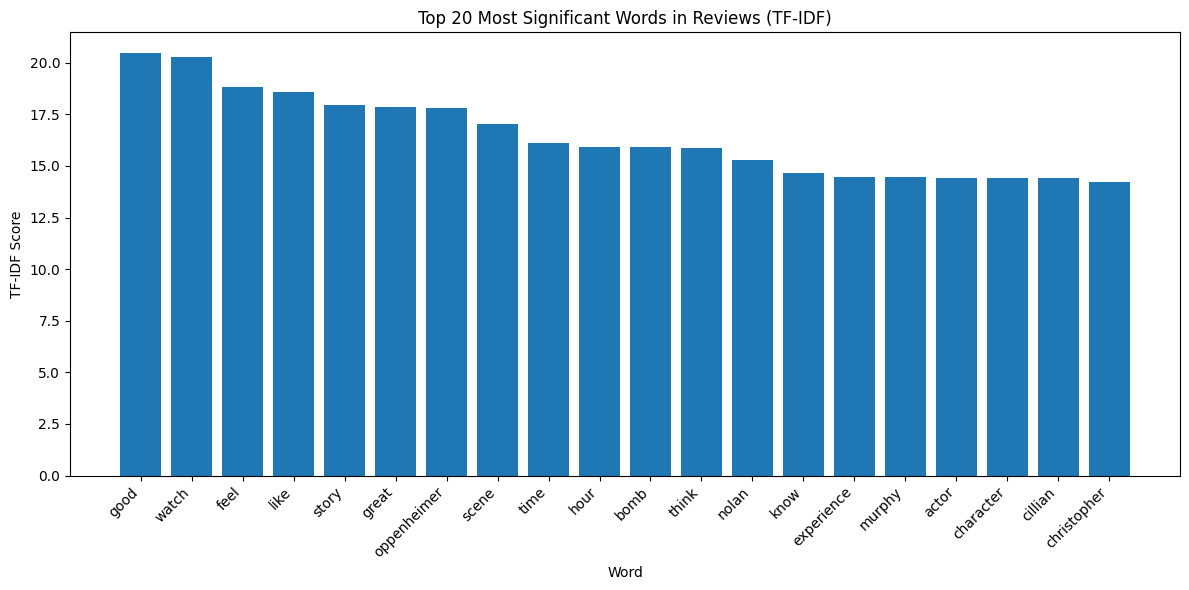

In [17]:
# Show most significant words using TF-IDF corpus
tfidf_top_words(dataset,20)

### N-grams Analysis


In [18]:
from collections import Counter

# Generate bigrams and trigrams
def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i+n])
        ngrams.append(ngram)
    return ngrams

def execute_ngram(data,n_gram,n_words):
    # Use the function to generate bigrams
    data[f'{n_gram}-grams'] = data['Tokens'].apply(lambda x: generate_ngrams(x, n_gram))
    data[f'{n_gram}-grams Tokens'] = data[f'{n_gram}-grams'].apply(lambda x: [' '.join(words) for words in x])
    # Flatten the bigrams lists and convert them to tuples
    all_bigrams = [tuple(bigram) for bigrams_list in dataset[f'{n_gram}-grams'] for bigram in bigrams_list]

    bigram_freq = Counter(all_bigrams)

    # Convert the Counter to a pandas DataFrame
    df_bigram_freq = pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['Frequency'])

    # Sort the DataFrame based on frequency in descending order
    df_bigram_freq = df_bigram_freq.sort_values(by='Frequency', ascending=False)

    # Get the top 20 most frequent bigrams and their frequencies
    top_20_bigrams = df_bigram_freq.index[:n_words]
    top_20_frequencies = df_bigram_freq['Frequency'][:n_words]

    # Convert tuples to strings with separator
    top_20_bigrams_str = [' '.join(bigram) for bigram in top_20_bigrams]

    # Plot the bigram frequencies in a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(top_20_bigrams_str, top_20_frequencies)
    plt.xlabel(f"{n_gram}-gram")
    plt.ylabel("Frequency")
    plt.title(f"Top {n_words} {n_gram}-gram Frequencies")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def tfidf_ngrams(data,n_gram,n_word):
    tfidf_top_words(data=data,n_gram=n_gram,n=n_word)

#### Bigrams Analysis

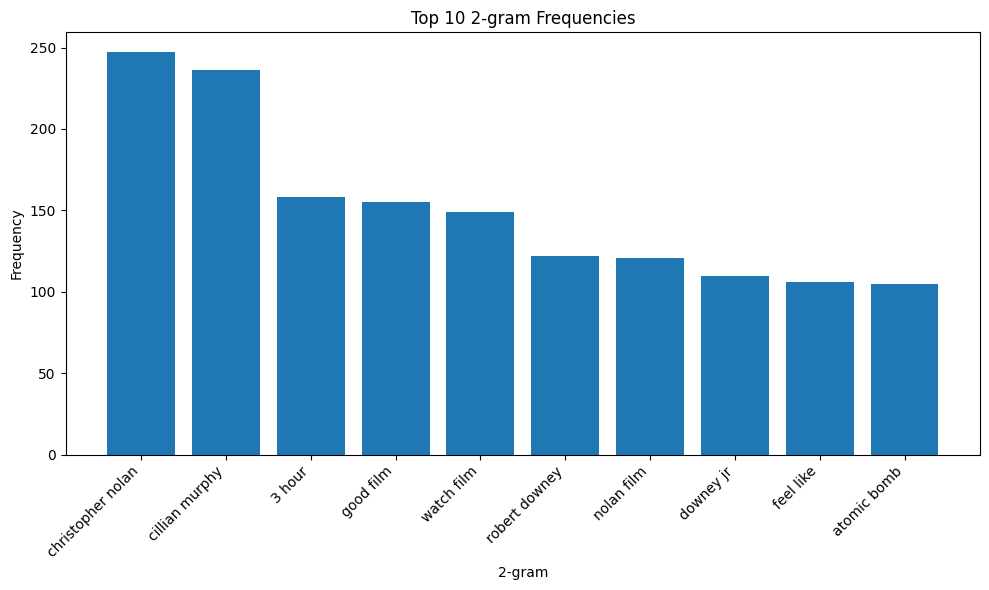

In [19]:
# Execute Bigram
execute_ngram(dataset,2,10)

#### Trigrams Analysis

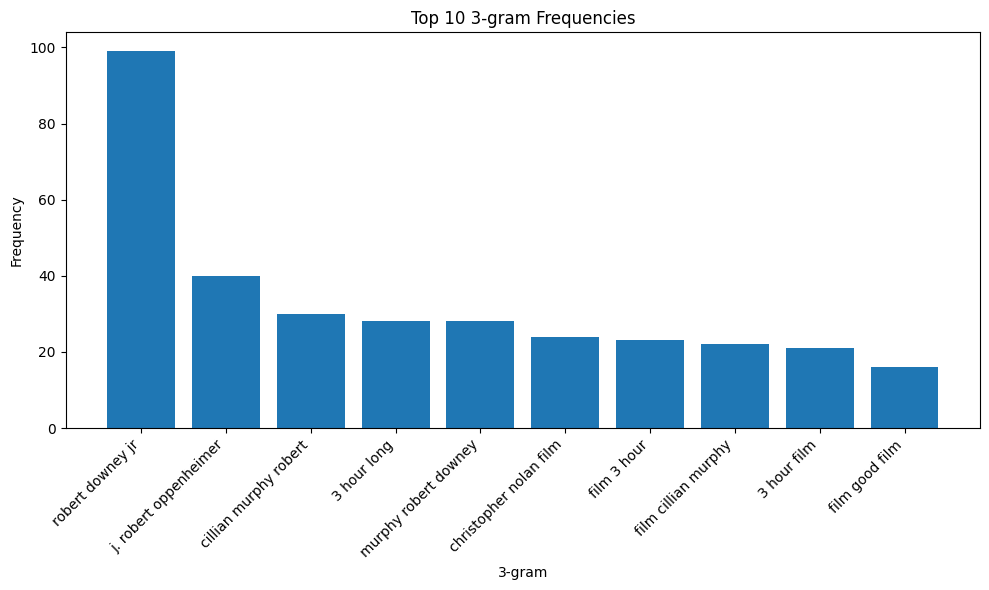

In [23]:
# Execute trigrams
execute_ngram(dataset,3,10)

## 4. Sentiment Analysis using BERT

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Import BERT as pretrained model to be used on sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Write function to execute sentiment score from 1-5
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [26]:
# Iterations for calculating each review score
scores=[]
for review in dataset['Reviews']:
    tmp_score=sentiment_score(review)
    scores.append(tmp_score)

# Assign
dataset['Score']=scores

In [27]:
# Iterations for calculating each score frequencies
frequencies=[]
for item in np.sort(dataset['Score'].unique()):
    tmp_freq=len(dataset.loc[dataset['Score']==item])
    frequencies.append(tmp_freq)

# Displaying each score frequencies in order from 1 to 5
frequencies
        

[188, 77, 87, 158, 309]

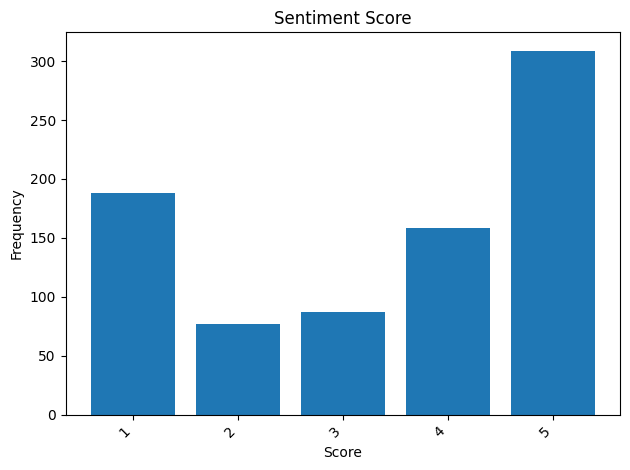

In [28]:
# Plot the bar chart for each sentiment score
plt.bar(np.sort(dataset['Score'].unique()),frequencies)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## 5. Analysis on Sentiment 1 and 5

In [29]:
# Analyze the reviews that has the sentiment score of 1 and 5
df_5=dataset.loc[dataset['Score']==5]
df_1=dataset.loc[dataset['Score']==1]

In [30]:
df_1.head()

,Reviews,Tokens,2-grams,2-grams Tokens,3-grams,3-grams Tokens,5-grams,5-grams Tokens,4-grams,4-grams Tokens,Score
3,find film hate boring know know piece history ...,"[find, film, hate, boring, know, know, piece, ...","[(find, film), (film, hate), (hate, boring), (...","[find film, film hate, hate boring, boring kno...","[(find, film, hate), (film, hate, boring), (ha...","[find film hate, film hate boring, hate boring...","[(find, film, hate, boring, know), (film, hate...","[find film hate boring know, film hate boring ...","[(find, film, hate, boring), (film, hate, bori...","[find film hate boring, film hate boring know,...",1
6,time pass quickly ultimately oppenheimer leave...,"[time, pass, quickly, ultimately, oppenheimer,...","[(time, pass), (pass, quickly), (quickly, ulti...","[time pass, pass quickly, quickly ultimately, ...","[(time, pass, quickly), (pass, quickly, ultima...","[time pass quickly, pass quickly ultimately, q...","[(time, pass, quickly, ultimately, oppenheimer...","[time pass quickly ultimately oppenheimer, pas...","[(time, pass, quickly, ultimately), (pass, qui...","[time pass quickly ultimately, pass quickly ul...",1
14,film experience direction cinematography music...,"[film, experience, direction, cinematography, ...","[(film, experience), (experience, direction), ...","[film experience, experience direction, direct...","[(film, experience, direction), (experience, d...","[film experience direction, experience directi...","[(film, experience, direction, cinematography,...",[film experience direction cinematography musi...,"[(film, experience, direction, cinematography)...","[film experience direction cinematography, exp...",1
20,nolan strangely petentious film bad right away...,"[nolan, strangely, petentious, film, bad, righ...","[(nolan, strangely), (strangely, petentious), ...","[nolan strangely, strangely petentious, petent...","[(nolan, strangely, petentious), (strangely, p...","[nolan strangely petentious, strangely petenti...","[(nolan, strangely, petentious, film, bad), (s...","[nolan strangely petentious film bad, strangel...","[(nolan, strangely, petentious, film), (strang...","[nolan strangely petentious film, strangely pe...",1
21,amazing film visual sound music act direct 10/...,"[amazing, film, visual, sound, music, act, dir...","[(amazing, film), (film, visual), (visual, sou...","[amazing film, film visual, visual sound, soun...","[(amazing, film, visual), (film, visual, sound...","[amazing film visual, film visual sound, visua...","[(amazing, film, visual, sound, music), (film,...","[amazing film visual sound music, film visual ...","[(amazing, film, visual, sound), (film, visual...","[amazing film visual sound, film visual sound ...",1


Used Tokens


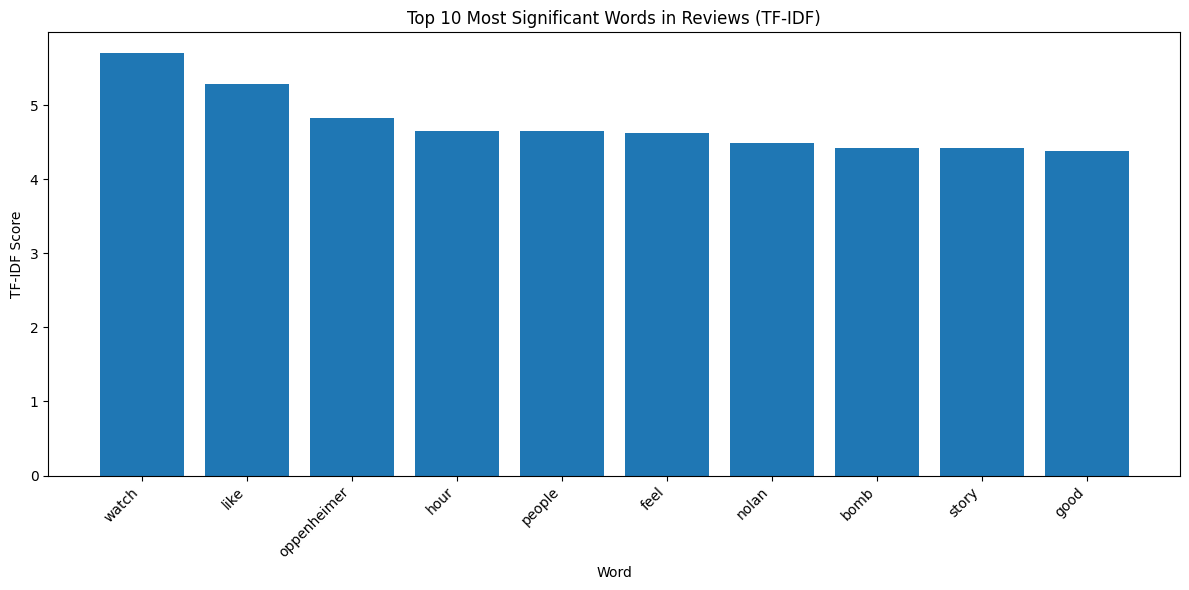

In [32]:
# Apply TF-IDF on top words for reviews that have the sentiment score of 1
tfidf_top_words(df_1,10)

Used Tokens


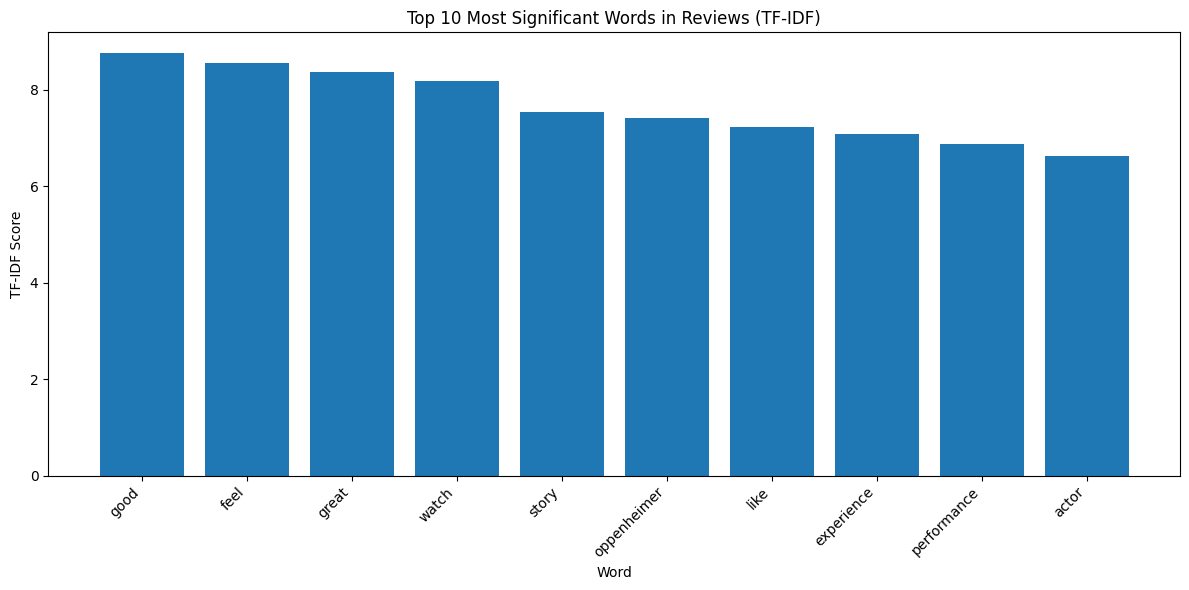

In [34]:
# Apply TF-IDF on top words for reviews that have the sentiment score of 5
tfidf_top_words(df_5,10)

Used 2-Grams


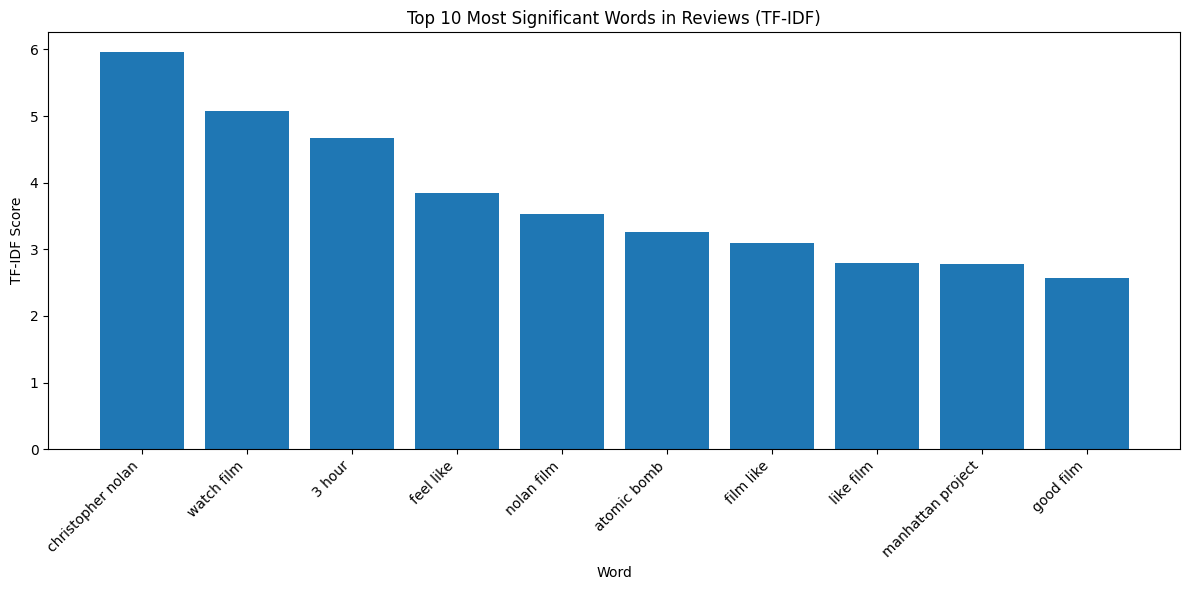

In [42]:
# Apply TF-IDF on bigrams for reviews that have the sentiment score of 1
tfidf_ngrams(data=df_1,n_gram=2,n_word=10)

Used 2-Grams


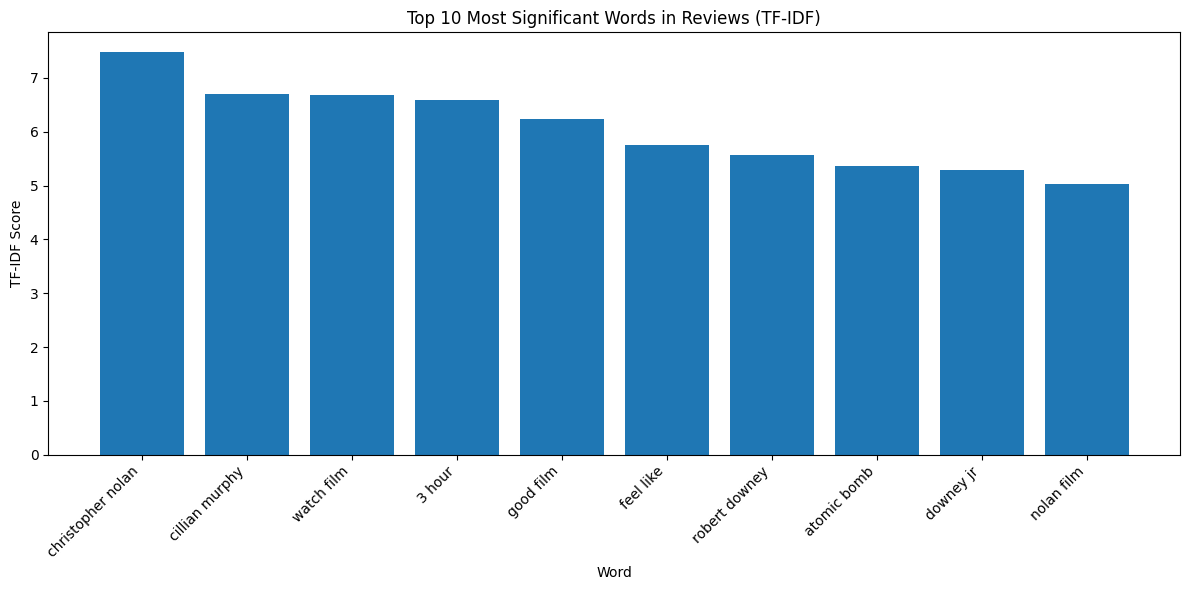

In [43]:
# Apply TF-IDF on bigrams for reviews that have the sentiment score of 5
tfidf_ngrams(data=df_5,n_gram=2,n_word=10)

Used 3-Grams


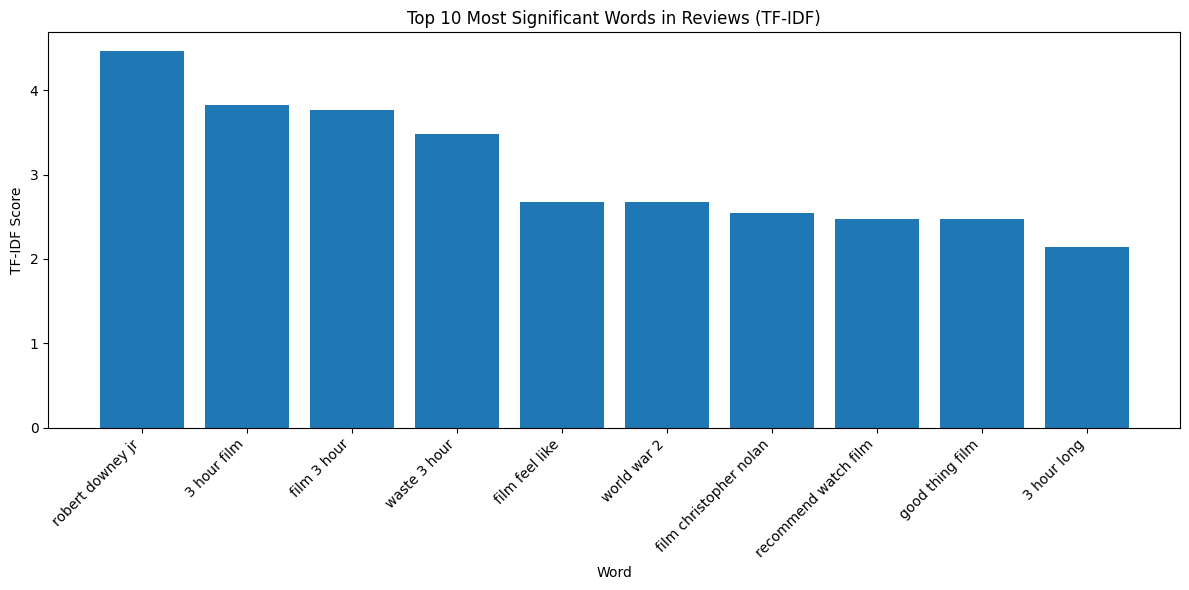

In [44]:
# Apply TF-IDF on trigrams for reviews that have the sentiment score of 1
tfidf_ngrams(data=df_1,n_gram=3,n_word=10)

Used 3-Grams


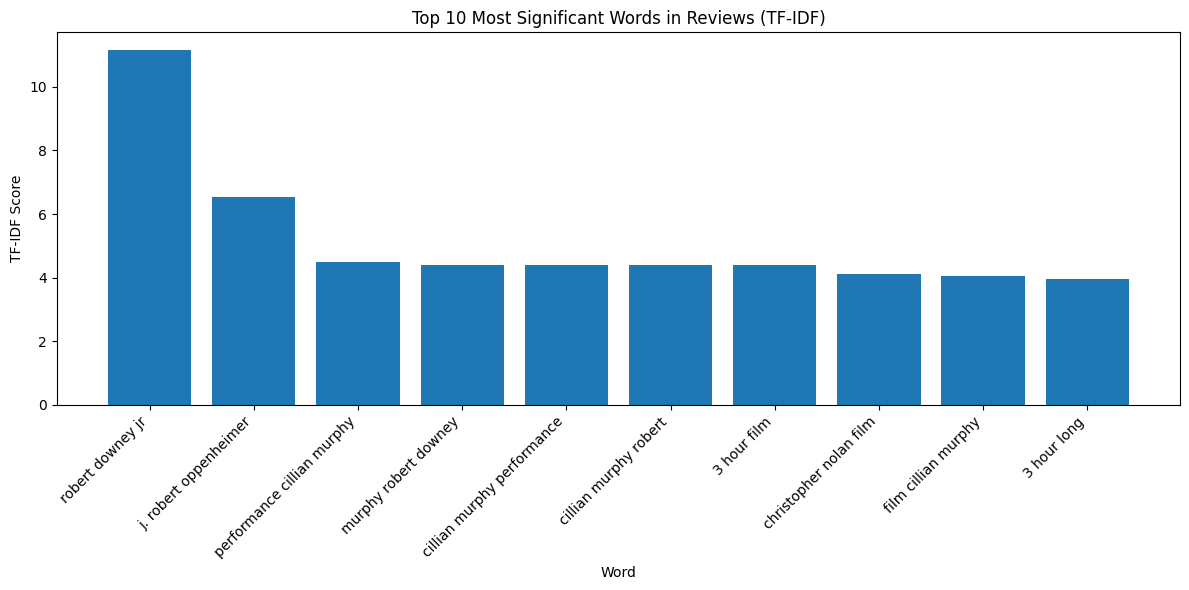

In [45]:
# Apply TF-IDF on bigrams for reviews that have the sentiment score of 5
tfidf_ngrams(data=df_5,n_gram=3,n_word=10)